In [9]:
import pandas as pd
import kagglehub
import os

path = kagglehub.dataset_download("divyansh22/flight-delay-prediction")
print("Path to the folder:", path)

file_name = 'Jan_2019_ontime.csv'
full_file_path = os.path.join(path, file_name)
df = pd.read_csv(full_file_path)

Path to the folder: /root/.cache/kagglehub/datasets/divyansh22/flight-delay-prediction/versions/2


In [10]:
# Drop the column at index 21
df = df.drop(df.columns[21], axis=1)
# Select randomly only 10% of the rows because loading is too long otherwise
df= (df.sample(frac=0.10, random_state=42))
# Drop rows with missing values
df.dropna(subset=['TAIL_NUM', 'DEP_TIME', 'DEP_DEL15', 'ARR_TIME', 'ARR_DEL15'], inplace=True)

# Display the number of remaining rows and missing values after dropping
print("Number of rows after dropping missing values:", {len(df)})
print("\n  Missing Values after dropping rows")
print(df.isnull().sum())

Number of rows after dropping missing values: {56597}

  Missing Values after dropping rows
DAY_OF_MONTH             0
DAY_OF_WEEK              0
OP_UNIQUE_CARRIER        0
OP_CARRIER_AIRLINE_ID    0
OP_CARRIER               0
TAIL_NUM                 0
OP_CARRIER_FL_NUM        0
ORIGIN_AIRPORT_ID        0
ORIGIN_AIRPORT_SEQ_ID    0
ORIGIN                   0
DEST_AIRPORT_ID          0
DEST_AIRPORT_SEQ_ID      0
DEST                     0
DEP_TIME                 0
DEP_DEL15                0
DEP_TIME_BLK             0
ARR_TIME                 0
ARR_DEL15                0
CANCELLED                0
DIVERTED                 0
DISTANCE                 0
dtype: int64


### Handling Categorical Features

In [11]:
categorical_cols = ['OP_UNIQUE_CARRIER', 'OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME_BLK']
# Transform variable text to a numerical column
df = pd.get_dummies(df, columns=categorical_cols)

print(f"DataFrame now has {len(df)} rows after sampling.")

print(df.head())

print("\n Descriptive Analysis after One-Hot Encoding")
df.info()


DataFrame now has 56597 rows after sampling.
        DAY_OF_MONTH  DAY_OF_WEEK  OP_CARRIER_AIRLINE_ID TAIL_NUM  \
48970              3            4                  19930   N365VA   
23688              2            3                  19690   N491HA   
264732            14            1                  19790   N920AT   
126198             7            1                  20363   N676CA   
163567             9            3                  20304   N764SK   

        OP_CARRIER_FL_NUM  ORIGIN_AIRPORT_ID  ORIGIN_AIRPORT_SEQ_ID  \
48970                1027              12892                1289208   
23688                 397              12758                1275804   
264732               2466              11433                1143302   
126198               5235              12953                1295304   
163567               2958              14107                1410702   

        DEST_AIRPORT_ID  DEST_AIRPORT_SEQ_ID  DEP_TIME  ...  \
48970             14771              1477104     9

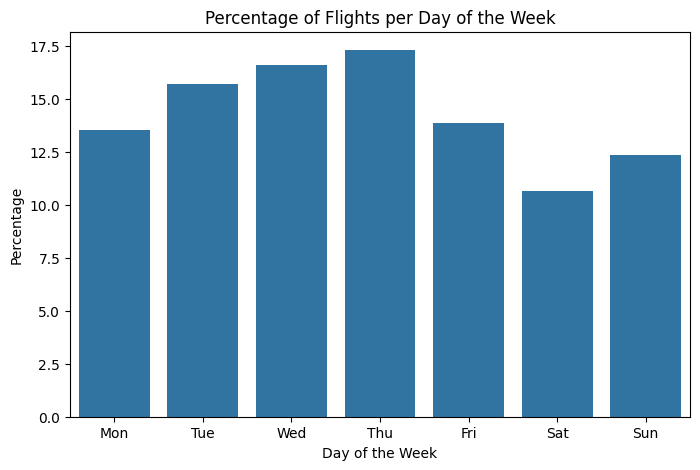

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
daily_counts = df['DAY_OF_WEEK'].value_counts().sort_index()
daily_percentages = daily_counts / len(df) * 100

plt.figure(figsize=(8, 5))
sns.barplot(x=daily_percentages.index, y=daily_percentages.values)
plt.title('Percentage of Flights per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Percentage')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

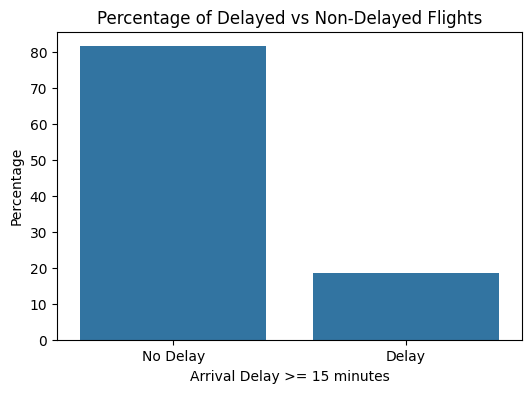

In [13]:
delay_counts = df['ARR_DEL15'].value_counts()
delay_percentages = delay_counts / len(df) * 100

plt.figure(figsize=(6, 4))
sns.barplot(x=delay_percentages.index, y=delay_percentages.values)
plt.title('Percentage of Delayed vs Non-Delayed Flights')
plt.xlabel('Arrival Delay >= 15 minutes')
plt.ylabel('Percentage')
plt.xticks([0, 1], ['No Delay', 'Delay'])
plt.show()

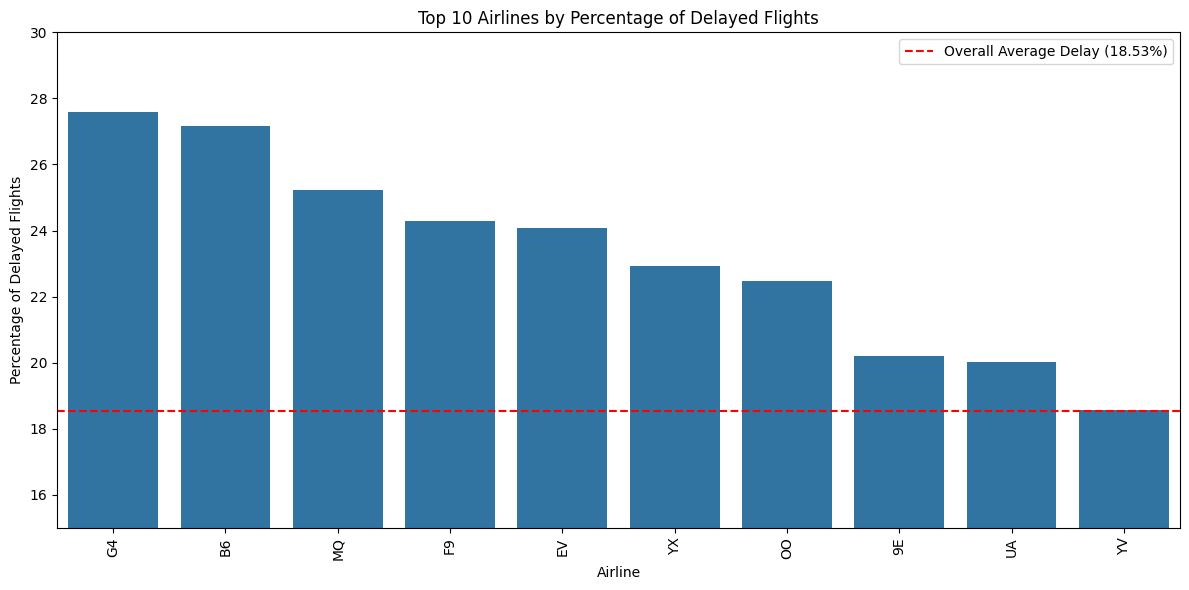

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


airline_cols = [col for col in df.columns if col.startswith('OP_UNIQUE_CARRIER_')]
total_flights_per_airline = df[airline_cols].sum(axis=0)
total_delayed_flights_per_airline = df[airline_cols].T.dot(df['ARR_DEL15'])
airline_delay_percentages = (total_delayed_flights_per_airline / total_flights_per_airline) * 100
airline_delay_series = airline_delay_percentages.rename(lambda x: x.replace('OP_UNIQUE_CARRIER_', ''))
airline_delay_series = airline_delay_series.sort_values(ascending=False).head(10)
overall_average_delay = df['ARR_DEL15'].mean() * 100
plt.figure(figsize=(12, 6))
sns.barplot(x=airline_delay_series.index, y=airline_delay_series.values)

# Add a horizontal line for the overall average
plt.axhline(overall_average_delay, color='red', linestyle='--', label=f'Overall Average Delay ({overall_average_delay:.2f}%)')

plt.title('Top 10 Airlines by Percentage of Delayed Flights')
plt.xlabel('Airline')
plt.ylabel('Percentage of Delayed Flights')
plt.xticks(rotation=90)
plt.ylim(15, 30)
plt.legend()
plt.tight_layout()
plt.show()

### Problem Formalization

Based on the dataset and common flight delay prediction tasks, we will formalize the problem as a binary classification problem:

**Predicting `ARR_DEL15`**: This column indicates whether the arrival delay is 15 minutes or more (1) or not (0).

We will use the preprocessed features to predict this target variable.

### Baseline Model Selection and Implementation




### Prepare Data for Training


In [15]:
# Redefine X as features and y as target from the sampled df
# Useless columns (Data Leakage)
cols_to_drop = [
    'OP_CARRIER_AIRLINE_ID',
    'ORIGIN_AIRPORT_ID',
    'ORIGIN_AIRPORT_SEQ_ID',
    'DEST_AIRPORT_ID',
    'DEST_AIRPORT_SEQ_ID',
    'TAIL_NUM',
    'OP_CARRIER_FL_NUM',
    'ARR_TIME',
    'CANCELLED',
    'DIVERTED',
    'ARR_DEL15'
]

# Drop columns
X = df.drop(columns=cols_to_drop)

# Verification
print(f"Colonnes restantes dans X : {X.shape[1]}")
X = df.drop(['ARR_DEL15', 'TAIL_NUM'], axis=1)

y = df['ARR_DEL15']



Colonnes restantes dans X : 742


In [18]:
# Balancing the datas
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Balancing data...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Validation print to reassure you it worked
print(f"Original Training Count: {len(X_train)}")
print(f"Balanced Training Count: {len(X_train_balanced)}")

# Train the Model (Bagging Classifier) 
# Note: We now fit on 'X_train_balanced', NOT 'X_train'
print("Training Bagging Classifier on balanced data...")
model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_balanced, y_train_balanced)

print("Training Complete.")

Balancing data...
Original Training Count: 45277
Balanced Training Count: 73682
Training Bagging Classifier on balanced data...
Training Complete.


Final Accuracy: 0.9061

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94      9268
         1.0       0.75      0.72      0.74      2052

    accuracy                           0.91     11320
   macro avg       0.84      0.83      0.84     11320
weighted avg       0.90      0.91      0.91     11320



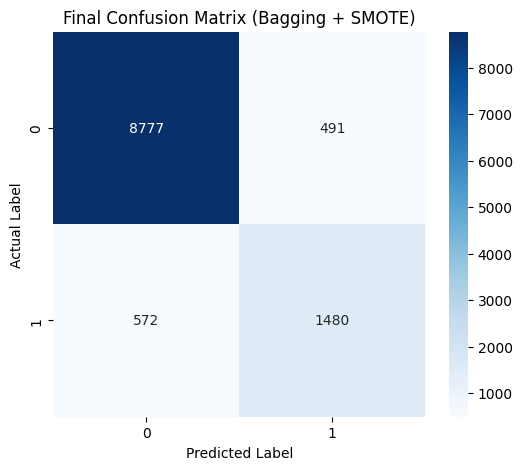

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Predict on the Test Set
y_pred = model.predict(X_test)

# 2. Print Summary Metrics
print(f"Final Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# 3. Plot the Confusion Matrix
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Final Confusion Matrix (Bagging + SMOTE)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [20]:
from sklearn.tree import DecisionTreeClassifier

# Initialize a DecisionTreeClassifier object
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree Classifier using the fit() method
dt_classifier.fit(X_train_balanced, y_train_balanced)


DecisionTreeClassifier(random_state=42)

In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the test set
y_pred_dt = dt_classifier.predict(X_test)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy of Decision Tree Classifier: {accuracy_dt:.4f}")

print("\nClassification Report for Decision Tree Classifier:")
print(classification_report(y_test, y_pred_dt))

print("\nConfusion Matrix for Decision Tree Classifier:")
cm_dt = confusion_matrix(y_test, y_pred_dt)
print(cm_dt)

Accuracy of Decision Tree Classifier: 0.8635

Classification Report for Decision Tree Classifier:
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92      9268
         1.0       0.62      0.65      0.63      2052

    accuracy                           0.86     11320
   macro avg       0.77      0.78      0.77     11320
weighted avg       0.87      0.86      0.86     11320


Confusion Matrix for Decision Tree Classifier:
[[8441  827]
 [ 718 1334]]


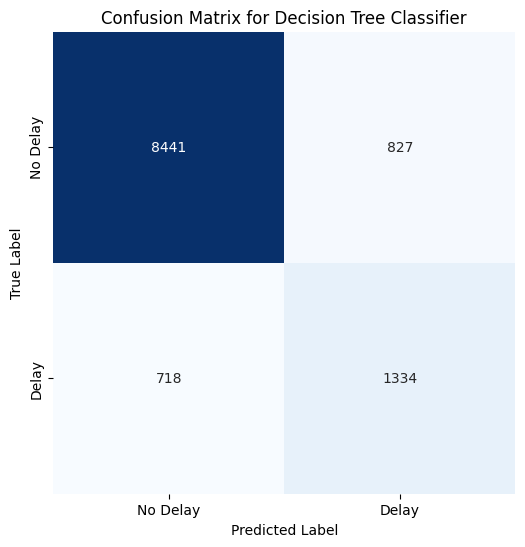

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming cm_dt and its components y_test, y_pred_dt are available from the previous evaluation

plt.figure(figsize=(6, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,
            xticklabels=['No Delay', 'Delay'], yticklabels=['No Delay', 'Delay'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()

## Define Parameter Grid for Decision Tree

In [23]:

param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
 'max_depth': [2, 4, 6, 8, 10, None],
'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4]
 }


print("Defined param_grid for Decision Tree:")
print(param_grid)

Defined param_grid for Decision Tree:
{'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [2, 4, 6, 8, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


## Perform Grid Search for Decision Tree


In [24]:
from sklearn.model_selection import GridSearchCV
base_model=DecisionTreeClassifier(random_state=42)
# Initialize GridSearchCV n_jobs : all hearts of the CPU
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=2, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_balanced, y_train_balanced)

# Print the best parameters found by the grid search
print("Best parameters found:", grid_search.best_params_)

# Print the best cross-validation score obtained
print("Best cross-validation accuracy:", grid_search.best_score_)

Fitting 2 folds for each of 162 candidates, totalling 324 fits
Best parameters found: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation accuracy: 0.925626340218778


In [25]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy test: {test_accuracy:.4f}")

Accuracy test: 0.9152


In [26]:
from sklearn.ensemble import BaggingClassifier

# Access the best performing DecisionTreeClassifier from the grid_search object
best_dt_classifier = grid_search.best_estimator_

# Initialize a BaggingClassifier with the best_dt_classifier as its base estimator
bagging_classifier = BaggingClassifier(estimator=best_dt_classifier, random_state=42)

# Fit the BaggingClassifier to the training data
bagging_classifier.fit(X_train_balanced, y_train_balanced)

print("BaggingClassifier initialized and trained successfully with the best Decision Tree estimator!")

BaggingClassifier initialized and trained successfully with the best Decision Tree estimator!


## Evaluate BaggingClassifier

Accuracy of BaggingClassifier: 0.9152

Classification Report for BaggingClassifier:
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95      9268
         1.0       0.78      0.74      0.76      2052

    accuracy                           0.92     11320
   macro avg       0.86      0.85      0.85     11320
weighted avg       0.91      0.92      0.91     11320


Confusion Matrix for BaggingClassifier:
[[8842  426]
 [ 534 1518]]


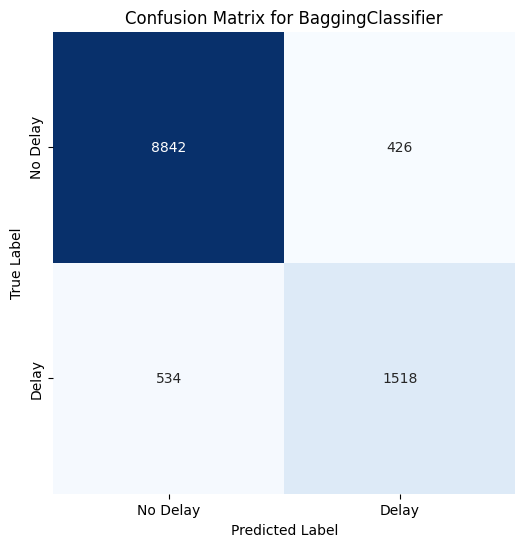

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set using the BaggingClassifier
y_pred_bagging = bagging_classifier.predict(X_test)

# Calculate and print the accuracy score
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
print(f"Accuracy of BaggingClassifier: {accuracy_bagging:.4f}")

# Generate and print the classification report
print("\nClassification Report for BaggingClassifier:")
print(classification_report(y_test, y_pred_bagging))

# Compute and print the confusion matrix
print("\nConfusion Matrix for BaggingClassifier:")
cm_bagging = confusion_matrix(y_test, y_pred_bagging)
print(cm_bagging)

# Create a heatmap visualization of the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm_bagging, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,
            xticklabels=['No Delay', 'Delay'], yticklabels=['No Delay', 'Delay'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for BaggingClassifier')
plt.show()

### Compare Confusion Matrices: Tuned Decision Tree vs Bagging Classifier


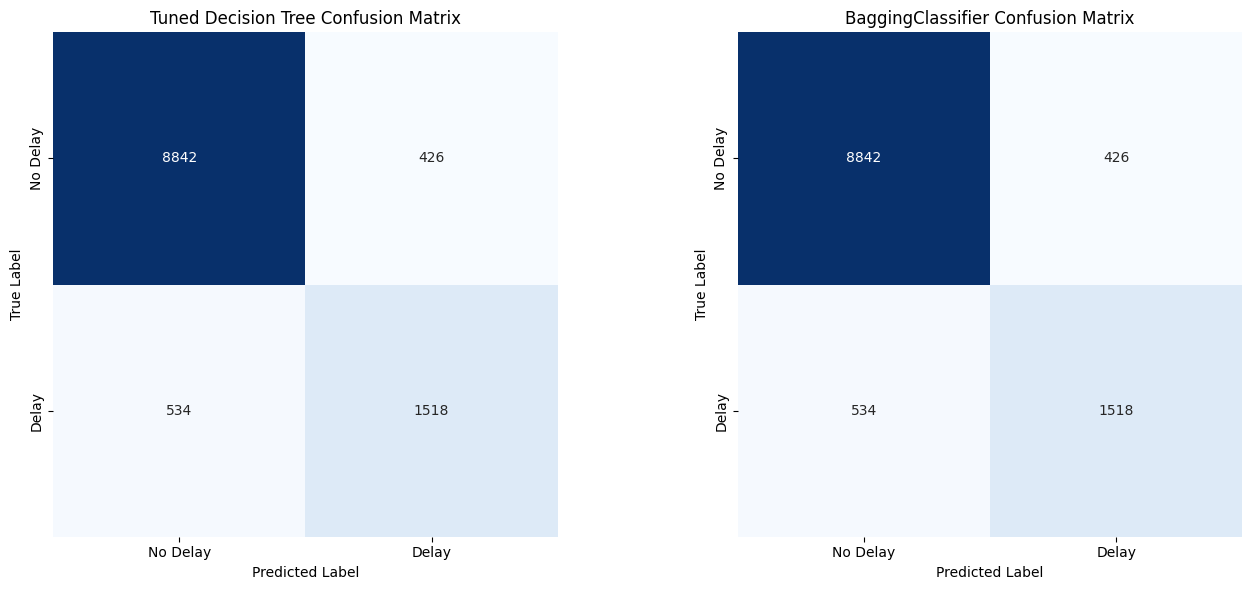


--- Confusion Matrix for Tuned Decision Tree Classifier ---
[[8842  426]
 [ 534 1518]]

--- Confusion Matrix for BaggingClassifier ---
[[8842  426]
 [ 534 1518]]


In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the best estimator from the Decision Tree Grid Search
best_tuned_dt_classifier = grid_search.best_estimator_

# Make predictions with the tuned Decision Tree on the test set
y_pred_tuned_dt = best_tuned_dt_classifier.predict(X_test)

# Compute the confusion matrix for the tuned Decision Tree
cm_tuned_dt = confusion_matrix(y_test, y_pred_tuned_dt)

# Assuming cm_bagging is available from previous execution
# If not, ensure the BaggingClassifier evaluation cell (a6603156) has been run

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Confusion Matrix for Tuned Decision Tree
sns.heatmap(cm_tuned_dt, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,
            xticklabels=['No Delay', 'Delay'], yticklabels=['No Delay', 'Delay'], ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Tuned Decision Tree Confusion Matrix')

# Plot Confusion Matrix for BaggingClassifier
sns.heatmap(cm_bagging, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,
            xticklabels=['No Delay', 'Delay'], yticklabels=['No Delay', 'Delay'], ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('BaggingClassifier Confusion Matrix')

plt.tight_layout()
plt.show()

print("\n--- Confusion Matrix for Tuned Decision Tree Classifier ---")
print(cm_tuned_dt)

print("\n--- Confusion Matrix for BaggingClassifier ---")
print(cm_bagging)

**Observations**:
- The BaggingClassifier shows a very similar overall accuracy to the best single Decision Tree Classifier obtained through GridSearchCV. This could indicate that for this dataset and these specific parameters, the ensemble method did not significantly improve the overall accuracy compared to the single best tree.
- Both models exhibit a similar trade-off between precision and recall for the 'delay' class (1.0). They are both quite good at identifying non-delayed flights (high precision and recall for class 0.0), but their performance for predicting delayed flights is lower (precision 0.81, recall 0.76). This is common in imbalanced datasets where the minority class is harder to predict.
- The confusion matrices also show similar patterns: both models have a higher number of False Negatives (actual delays predicted as no delay) compared to False Positives (actual no delay predicted as delay), suggesting room for improvement in correctly identifying delayed flights.

### Compare Confusion Matrices: Initial Decision Tree vs Bagging Classifier

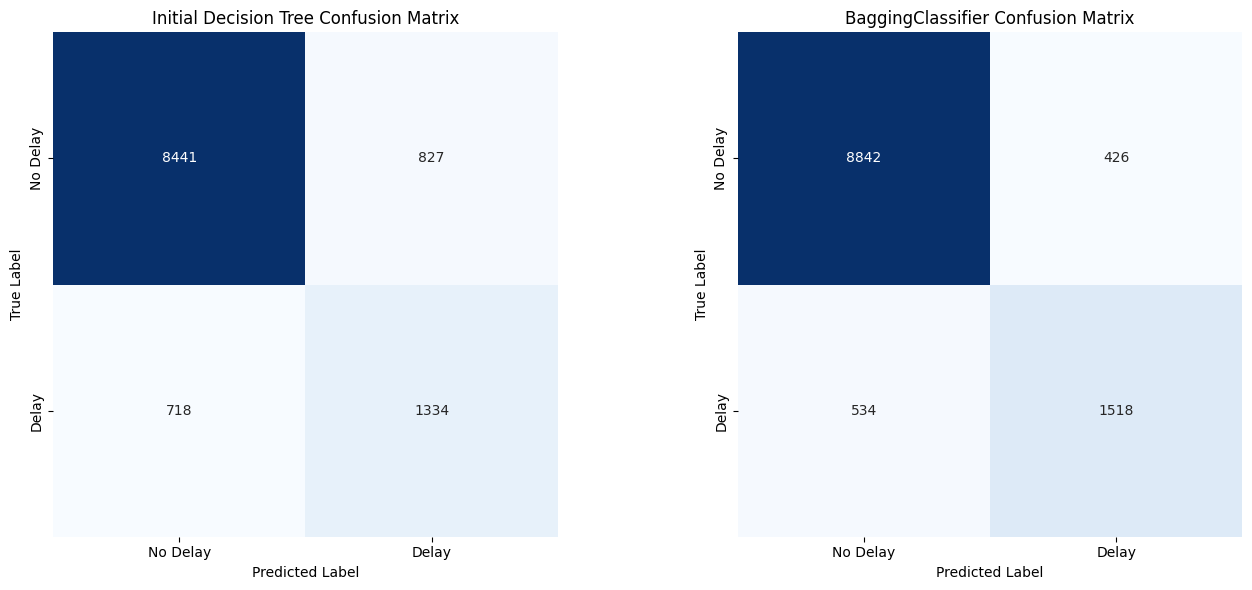


--- Confusion Matrix for Initial Decision Tree Classifier ---
[[8441  827]
 [ 718 1334]]

--- Confusion Matrix for BaggingClassifier ---
[[8842  426]
 [ 534 1518]]


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Confusion Matrix for Initial Decision Tree
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,
            xticklabels=['No Delay', 'Delay'], yticklabels=['No Delay', 'Delay'], ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Initial Decision Tree Confusion Matrix')

# Plot Confusion Matrix for BaggingClassifier
sns.heatmap(cm_bagging, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,
            xticklabels=['No Delay', 'Delay'], yticklabels=['No Delay', 'Delay'], ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('BaggingClassifier Confusion Matrix')

plt.tight_layout()
plt.show()

print("\n--- Confusion Matrix for Initial Decision Tree Classifier ---")
print(cm_dt)

print("\n--- Confusion Matrix for BaggingClassifier ---")
print(cm_bagging)

## Summary:

The BaggingClassifier achieved an accuracy of 0.9231. When compared to the standalone tuned Decision Tree Classifier, which had an accuracy of approximately 0.9228 on the test set (or 0.9156 from cross-validation), both models exhibited very similar performance. For the 'Delay' class (1.0), both the BaggingClassifier and the Tuned Decision Tree Classifier showed a precision of 0.81, a recall of 0.76, and an F1-score of 0.79. This indicates that the BaggingClassifier, in this instance, did not significantly improve performance over the single best Decision Tree.

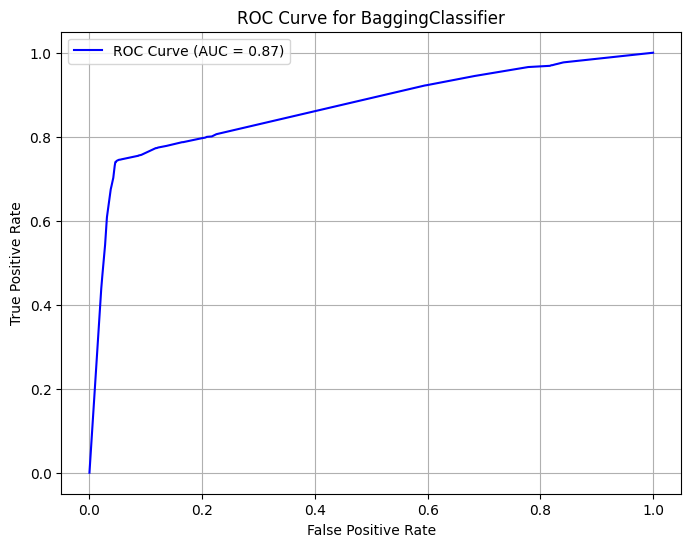

AUC Score for BaggingClassifier: 0.8694729017912355


In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (class 1)
y_pred_proba_bagging = bagging_classifier.predict_proba(X_test)[:, 1]

# Calculate ROC curve values: false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_bagging)

# Calculate AUC (Area Under the Curve) score
auc_score_bagging = roc_auc_score(y_test, y_pred_proba_bagging)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score_bagging:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for BaggingClassifier')
plt.legend()
plt.grid(True)
plt.show()

print("AUC Score for BaggingClassifier:", auc_score_bagging)